# Retinal pyramid and addition of saccades


## 1. Using only the Laplacian pyramid

### 1.1. Initialization parameters & functions

Parameters :

In [37]:
mode= 'bilinear' #resizing : continuous transition, reduces edges,contrast
width = 32 #side of the cropped image used to build the pyramid
base_levels = 1.61803
base_levels = 2 #downsampling/upsampling factor

N_batch = 4 #number of images 
name = 'i05june05_static_street_boston_p1010808'
#name = 'i05june05_static_street_boston_p1010764'
impath = '../data/'+name+'.jpeg'
locpath = '../data/'+name+'.pkl'

In [38]:
n_sublevel = 2 #filters dictionnary, number of sublevels
n_azimuth = 12 #retinal transform characteristics 
n_theta = 12
n_phase = 2

Libraries :

In [39]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

from SLIP import imread
from SLIP import Image as Image_SLIP
import time

from PIL import Image

In [40]:
import torch
torch.set_default_tensor_type('torch.DoubleTensor')

In [41]:
import imageio

In [42]:
from PYramid import local_filter
from torch.nn.functional import interpolate 
from PYramid import cropped_pyramid
from PYramid import inverse_pyramid

### Using torch to build up a Laplacian pyramid

In [43]:
from torch.nn.functional import interpolate 

In [44]:
img_orig = Image.open(impath)

img_color_npy = np.asarray(img_orig)
N_X, N_Y, _ = img_color_npy.shape #dimensions 

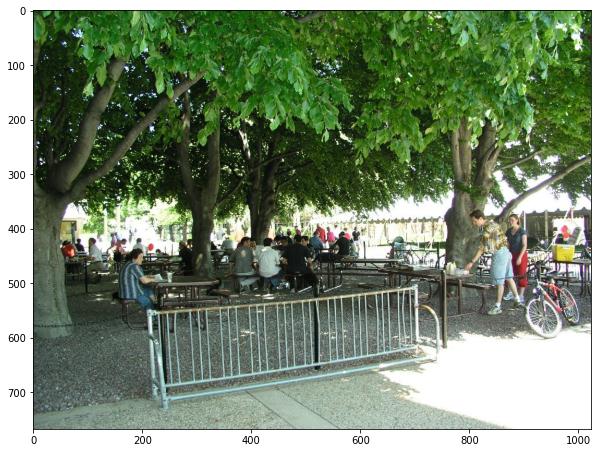

In [45]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img_color_npy/255)

In [46]:
import pickle
f = open(locpath,'rb')
loc_dict = pickle.load(f) # coordinates of the points of interest
loc_dict

{'image_name': 'i05june05_static_street_boston_p1010808',
 'barycenters': [(498, 384),
  (192, 425),
  (857, 437),
  (949, 513),
  (585, 546),
  (486, 288),
  (648, 415)]}

In [47]:
loc_data_xy = np.array(loc_dict['barycenters'])
loc_data_ij = []
for coord in loc_data_xy:
    loc_data_ij += [[coord[1], coord[0]]]
loc_data_ij = np.array(loc_data_ij)
nb_saccades = len(loc_dict['barycenters'])

In [48]:
nb_saccades

7

## Saccades list

In [49]:
from PYramid import saccade_to

In [50]:
orig = np.zeros(2, dtype='int')
orig[0] = N_X//2
orig[1] = N_Y//2
print("Coordinates of the center : ", orig) 

Coordinates of the center :  [384 512]


In [51]:
img_color_roll=[]
verbose=False
for i in range(len(loc_data_ij)):    
    #plt.imshow(img_color_roll[i])
    img_color_sac = saccade_to(img_color_npy, (N_X//2, N_Y//2), loc_data_ij[i])
    if verbose:
        plt.figure(figsize=(6,6))
        plt.imshow(img_color_sac)
        plt.plot(orig[1], orig[0], 'r+', ms=32)
    img_color_roll.append(img_color_sac)

## To Pytorch

In [52]:
img_tens = torch.Tensor(img_color_npy[None, ...]) 
img_tens = img_tens.permute(0,3,1,2)             #image's size stored in img_tens.shape[-2:]
print('Tensor shape=', img_tens.shape) 

Tensor shape= torch.Size([1, 3, 768, 1024])


## Cropped pyramid list

In [53]:
img_color_pyr_tens=[]
for i in range(len(loc_data_ij)):
    img_tens = torch.Tensor(img_color_roll[i][None, ...]) 
    img_tens = img_tens.permute(0,3,1,2)
    img_crop, level_size = cropped_pyramid(img_tens, do_mask=False,verbose=False)
    img_color_pyr_tens.append(img_crop)
print(level_size)

[[768, 1024], [384, 512], [192, 256], [96, 128], [48, 64], [24, 32]]


### Reconstruction from multiple saccades

In [54]:
from PYramid import inverse_pyramid_saccades

In [55]:
img_sac = inverse_pyramid_saccades(img_color_pyr_tens, loc_data_ij, level_size, verbose=False)

In [56]:
from pytorch_msssim import ssim, ms_ssim

Tensor shape= torch.Size([1, 3, 768, 1024])


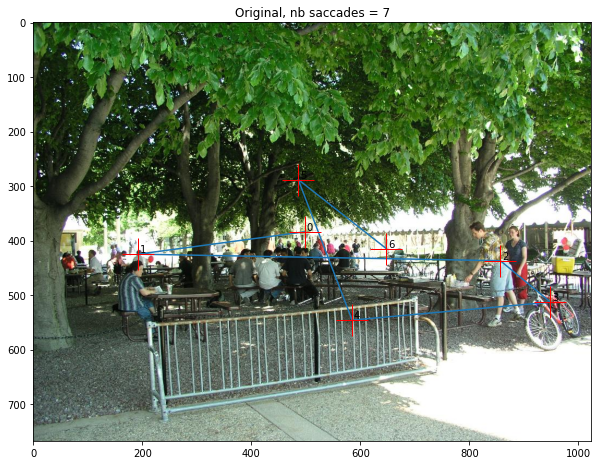

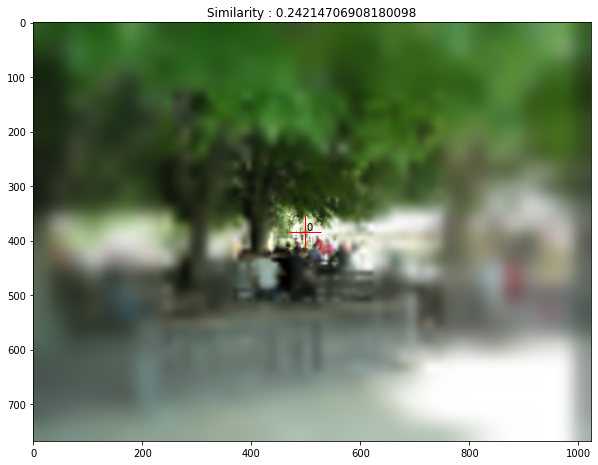

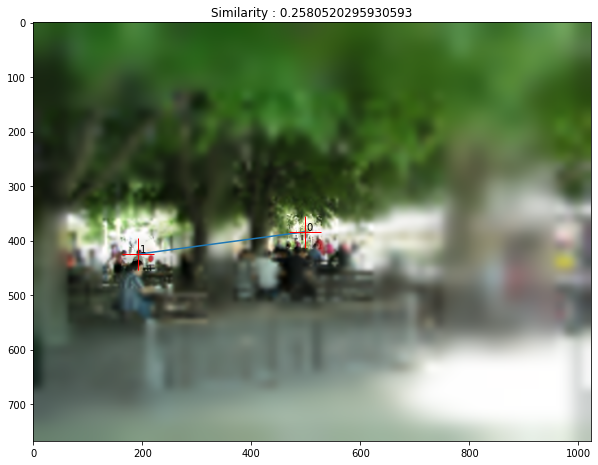

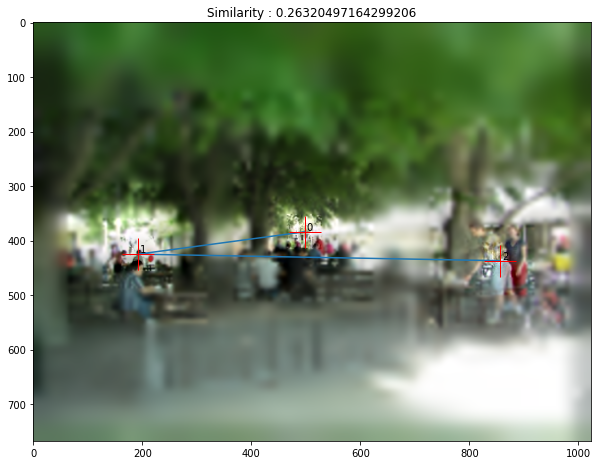

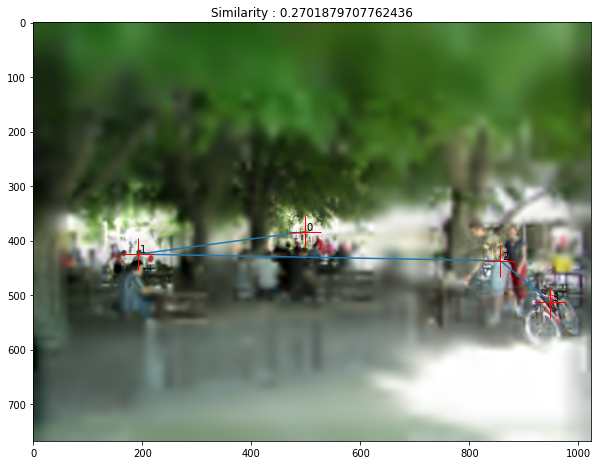

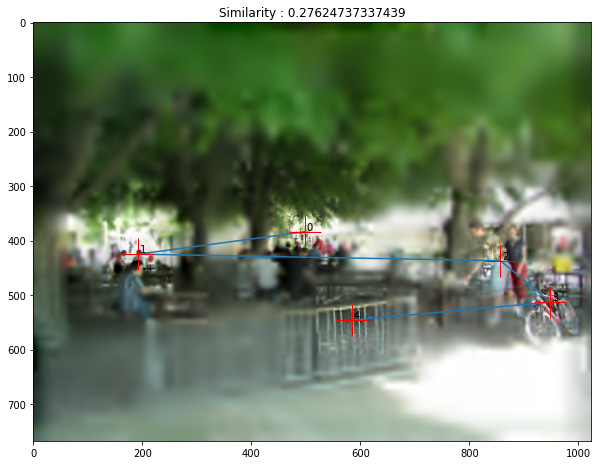

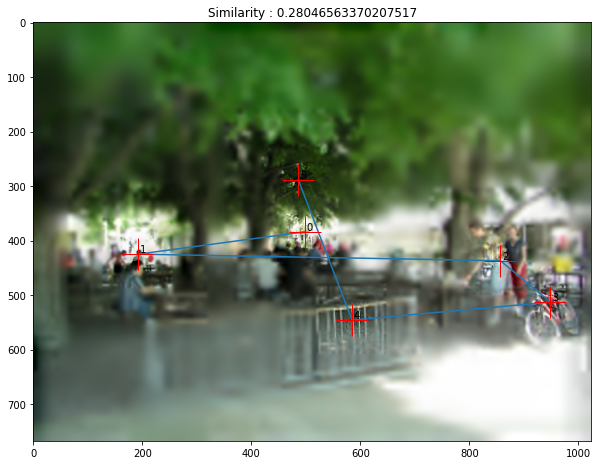

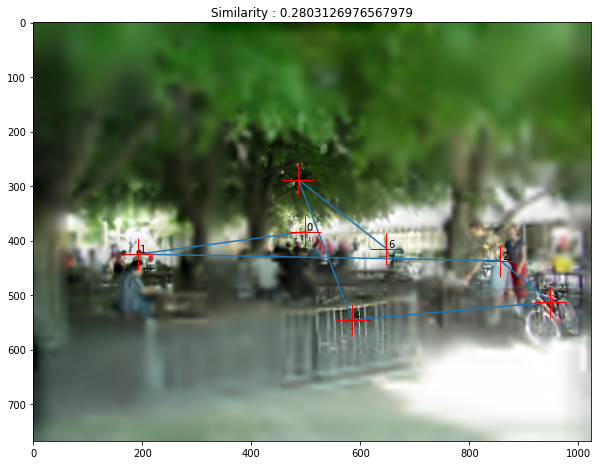

In [66]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img_color_npy, cmap='gray')

ax.plot(loc_data_xy[:,0], loc_data_xy[:,1])
for i, coord in enumerate(loc_data_xy):
    ax.plot(coord[0], coord[1], 'r+', ms=32)
    ax.text(coord[0]+3, coord[1]-3, i)
    ax.set_title('Original, nb saccades = '+str(nb_saccades))

sssim_list = []
cos_sim_list = []

img_tens = torch.Tensor(img_color_npy[None, ...]) 
img_tens = img_tens.permute(0,3,1,2)             #image's size stored in img_tens.shape[-2:]
print('Tensor shape=', img_tens.shape) 
    
for nb_saccades_part in range(1,nb_saccades+1):
    loc_data_ij_part = loc_data_ij[:nb_saccades_part]
    img_color_pyr_tens_part = img_color_pyr_tens[:nb_saccades_part]
    img_sac_part = inverse_pyramid_saccades(img_color_pyr_tens_part, loc_data_ij_part, level_size, verbose=False)    
    
    plt.figure(figsize=(10,10))
    img_sac_rec = img_sac_part.detach().permute(0,2,3,1)[0,:,:,:].numpy()
    img_sac_rec = np.clip(img_sac_rec,0,255).astype('uint8')

    plt.imshow(img_sac_rec)
    plt.plot(loc_data_ij_part[:,1], loc_data_ij_part[:,0])
    for i, coord in enumerate(loc_dict['barycenters'][:nb_saccades_part]):
        plt.plot(coord[0], coord[1], 'r+', ms=32)
        plt.text(coord[0]+3, coord[1]-3, i)
    sim_test = ssim(img_tens, img_sac_part, win_size=11, data_range=255).detach().numpy()
    cos_sim_test = torch.nn.CosineSimilarity()(img_tens.reshape(1,-1), img_sac_part.reshape(1,-1)).detach().numpy()
    plt.title('Similarity : '+ str(sim_test))
    sssim_list.append(sim_test)
    cos_sim_list.append(cos_sim_test)

Text(0.5, 1.0, 'Baseline Similarity : 0.23290782861652895')

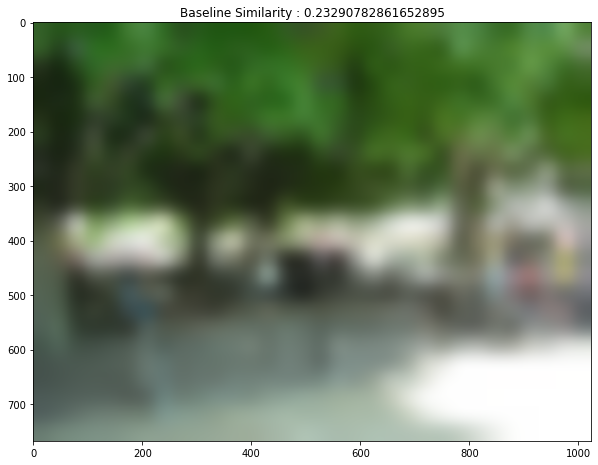

In [70]:
plt.figure(figsize=(10,10))
img_down = img_tens
for size in level_size[1:]:
    img_down = interpolate(img_down, size=size, mode='bilinear')
img_up = img_down
for size in level_size[4::-1]:
    img_up = interpolate(img_up, size=size, mode='bilinear')
img_aff = img_up.detach().permute(0,2,3,1)[0,:,:,:].numpy()
img_aff = np.clip(img_aff,0,255).astype('uint8')
plt.imshow(img_aff)
sim_test = ssim(img_tens, img_up, win_size=11, data_range=255).detach().numpy()
plt.title('Baseline Similarity : '+ str(sim_test))


Applying on the central crop of $32\times32$ and building the pyramid :

Text(0.5, 0, '# saccades')

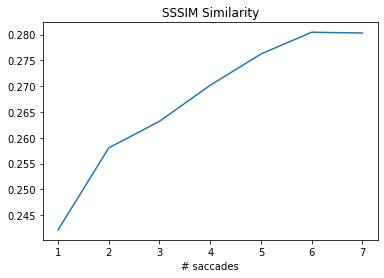

In [68]:
#import seaborn
#seaborn.set()
plt.plot(range(1,nb_saccades+1),sssim_list)
plt.title('SSSIM Similarity')
plt.xlabel('# saccades')

Text(0.5, 0, '# saccades')

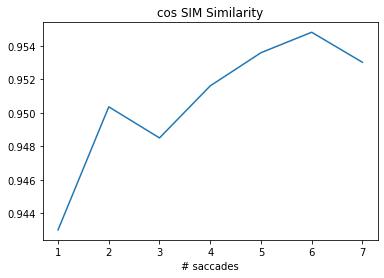

In [69]:
#import seaborn
#seaborn.set()
plt.plot(range(1,nb_saccades+1),cos_sim_list)
plt.title('cos Similarity')
plt.xlabel('# saccades')